In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dataset
from finetune import PrunningFineTuner
from ModifiedModels import ModifiedAlexNet
import time
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_dir = "Cat_Dog_data/"
train_path = dataset_dir+"train"
test_path = dataset_dir+"test"

In [4]:
train_data_loader = dataset.loader(train_path, size = 256)
test_data_loader = dataset.test_loader(test_path, size = 256)

In [5]:
alexnet = ModifiedAlexNet().to(device)
alexnet.eval()

ModifiedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias

In [6]:
epoches = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.classifier.parameters(), lr=0.0001, momentum=0.9)

In [7]:
def train(model, optimizer, epoches, train_data_loader,test_data_loader, device):
    
    for i in range(epoches):
        print("Epoch: ", i, end="  ")
        for i, (batch, label) in enumerate(train_data_loader):
            
            batch = batch.to(device)
            label = label.to(device)
            model.zero_grad()
            batch = Variable(batch)
            criterion(model(batch), Variable(label)).backward()
            optimizer.step()

        test(model, test_data_loader, device)

In [8]:
def test(model, test_data_loader, device):
    correct = 0
    total = 0
    for i, (batch, label) in enumerate(test_data_loader):
        batch = batch.to(device)
        output = model(Variable(batch))
        pred = output.data.max(1)[1]
        correct += pred.cpu().eq(label).sum()
        total += label.size(0)

    print("Accuracy :", float(correct) / total)

In [18]:
#Initial accuracy 
test(alexnet, test_data_loader, device)

#train fine tuned model
import time
start = time.time()
train(alexnet, optimizer, epoches, train_data_loader, test_data_loader, device)
end = time.time()
print("training time: ",end - start, " secs.")

Accuracy : 0.5084
Epoch:  0  Accuracy : 0.9436
Epoch:  1  Accuracy : 0.9524
Epoch:  2  Accuracy : 0.9568
Epoch:  3  Accuracy : 0.9576
Epoch:  4  Accuracy : 0.9596
training time:  550.8544845581055  secs.


In [10]:
torch.save(alexnet, "models/alexnet")

In [11]:
total_params = sum(p.numel() for p in alexnet.parameters())
print("Numbre of parameters:", total_params)

Numbre of parameters: 57012034


In [12]:
alexnet = torch.load("models/alexnet")

In [13]:
fine_tuner_alexnet = PrunningFineTuner(train_path, test_path, alexnet, device, size = 256)

In [14]:
def prune(model):
    hist = {"parameters":[], "accuracy":[], "filters":[], "accuracy_retrained_model":[]}
    
    hist["parameters"].append(model.get_number_of_parameters())
    hist["accuracy"].append(model.test())
    hist["filters"].append(model.total_num_filters())
    hist["accuracy_retrained_model"].append(model.test())
    
    number_of_filters = model.total_num_filters()
    filter_per_iteration = int(number_of_filters*0.2)
    
    for i in range(4):
        print("-------------------------------")
        acc = model.prune(filter_per_iteration)
        if(i%2 == 1):
            torch.save(model, "models/alexnet_prunned"+str(i))
        hist["parameters"].append(model.get_number_of_parameters())
        hist["accuracy"].append(acc)
        hist["filters"].append(model.total_num_filters())
        hist["accuracy_retrained_model"].append(model.test())
    return hist

In [15]:
#prune the filters in the model
hist = prune(fine_tuner_alexnet)

-------------------------------
Accuracy before pruning: 0.9544
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {6: 92, 8: 49, 10: 58, 3: 26, 0: 5}
Prunning filters.. 
Filters prunned 19.96527777777778%
Accuracy after pruning: 0.8612
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9532
Epoch:  1
Accuracy : 0.964
Epoch:  2
Accuracy : 0.96
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.96
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {6: 81, 3: 27, 8: 61, 10: 53, 0: 8}
Prunning filters.. 
Filters prunned 24.945770065075923%
Accuracy after pruning: 0.9296
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9564
Epoch:  1
Accuracy : 0.9504
Epoch:  2
Accuracy : 0.956
Finished fine tuning.


/home/cisd-greigra/anaconda/envs/pruning/lib/python3.8/site-packages/torch/utils/hooks.py:57: UserWarning: backward hook <bound method FilterPrunner.compute_rank of <finetune.FilterPrunner object at 0x7f78504bd3a0>> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "


-------------------------------
Accuracy before pruning: 0.956
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {8: 54, 6: 68, 10: 57, 3: 36, 0: 15}
Prunning filters.. 
Filters prunned 33.23699421965318%
Accuracy after pruning: 0.8288
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9012
Epoch:  1
Accuracy : 0.944
Epoch:  2
Accuracy : 0.946
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.946
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {3: 52, 8: 45, 6: 84, 0: 8, 10: 41}
Prunning filters.. 
Filters prunned 49.78354978354978%
Accuracy after pruning: 0.648
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9044
Epoch:  1
Accuracy : 0.924
Epoch:  2
Accuracy : 0.9116
Finished fine tuning.


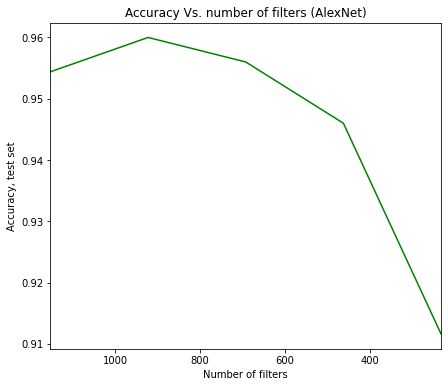

In [16]:
plt.figure(figsize=(7, 6))
plt.plot(hist["filters"], hist["accuracy_retrained_model"], color='green')
plt.xlabel('Number of filters')
plt.ylabel('Accuracy, test set')
plt.xlim(hist["filters"][0], hist["filters"][-1])
plt.title("Accuracy Vs. number of filters (AlexNet)")
#plt.legend()
plt.savefig('images/prunningfiltersAlexNet.png')

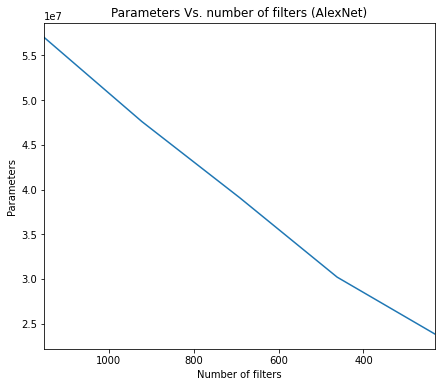

In [17]:
plt.figure(figsize=(7, 6))
plt.plot(hist["filters"], hist["parameters"])
plt.xlabel('Number of filters')
plt.ylabel('Parameters')
plt.xlim(hist["filters"][0], hist["filters"][-1])
plt.title("Parameters Vs. number of filters (AlexNet)")
plt.savefig('images/parametersAlexNet.png')